In [25]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
%matplotlib inline
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [26]:
def get_variable(x):
    x = Variable(x)
    return x.cuda() if torch.cuda.is_available() else x

In [27]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.5,],std=[0.5,])])

In [28]:
data_train = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [29]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 64,
                                                shuffle = True,
                                                 num_workers=2)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = 64,
                                               shuffle = True,
                                                num_workers=2)

[tensor(9), tensor(5), tensor(4), tensor(3), tensor(9), tensor(7), tensor(7), tensor(0), tensor(3), tensor(1), tensor(8), tensor(7), tensor(4), tensor(5), tensor(3), tensor(4), tensor(7), tensor(2), tensor(0), tensor(5), tensor(8), tensor(7), tensor(3), tensor(3), tensor(0), tensor(7), tensor(8), tensor(0), tensor(1), tensor(0), tensor(0), tensor(8), tensor(2), tensor(1), tensor(6), tensor(1), tensor(7), tensor(4), tensor(3), tensor(4), tensor(3), tensor(5), tensor(4), tensor(3), tensor(2), tensor(4), tensor(7), tensor(7), tensor(5), tensor(5), tensor(2), tensor(6), tensor(7), tensor(5), tensor(5), tensor(1), tensor(7), tensor(0), tensor(5), tensor(4), tensor(8), tensor(7), tensor(7), tensor(7)]


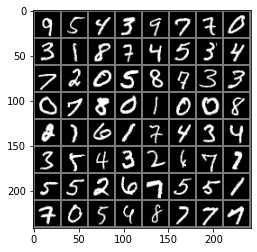

In [31]:
images,labels=next(iter(data_loader_train))
img=torchvision.utils.make_grid(images)
img=img.numpy().transpose(1,2,0)
std=[0.5,0.5,0.5]
mean=[0.5,0.5,0.5]
img=img*std+mean 
#if img.mode != 'L':
#  img = img.convert('L')
print([labels[i] for i in range(64)])
plt.imshow(img)
plt.show()

In [33]:
# 构建卷积神经网络模型
class CNN_Model(torch.nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.conv2=torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2, kernel_size=2))
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(7 * 7 * 128, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(1024, 10))
    # 前向传播
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x = x2.view(-1, 7 * 7 * 128)
        x = self.dense(x)
        return x

In [34]:
# 对模型进行训练和参数优化
cnn_model = CNN_Model()
# 将所有的模型参数移动到GPU上
if torch.cuda.is_available():
    cnn_model = cnn_model.cuda()
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(),lr=learning_rate)
for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0.0
    print("Epoch  {}/{}".format(epoch, num_epochs))
    for data in data_loader_train:
        X_train, y_train = data
        X_train, y_train = get_variable(X_train),get_variable(y_train)
        outputs = cnn_model(X_train)
        _, pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = loss_func(outputs, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += torch.sum(pred == y_train.data)
    testing_correct = 0.0
    for data in data_loader_test:
        X_test, y_test = data
        X_test, y_test = get_variable(X_test),get_variable(y_test)
        outputs = cnn_model(X_test)
        _, pred = torch.max(outputs, 1) #返回每一行中最大值的那个元素，且返回其索引
        testing_correct += torch.sum(pred == y_test.data)
        # print(testing_correct)
    print("Loss is :{:.4f},Train Accuracy is:{:.4f}%,Test Accuracy is:{:.4f}%".format(
        running_loss / len(data_train), 100 * running_correct / len(data_train),
        100 * testing_correct / len(data_test)))
torch.save(cnn_model, 'data/cnn_model.pt')

Epoch  0/10
Loss is :0.0032,Train Accuracy is:94.4417%,Test Accuracy is:97.3200%
Epoch  1/10
Loss is :0.0013,Train Accuracy is:97.5583%,Test Accuracy is:97.9000%
Epoch  2/10
Loss is :0.0010,Train Accuracy is:98.1983%,Test Accuracy is:98.3000%
Epoch  3/10
Loss is :0.0007,Train Accuracy is:98.5667%,Test Accuracy is:98.2800%
Epoch  4/10
Loss is :0.0006,Train Accuracy is:98.8517%,Test Accuracy is:98.5400%
Epoch  5/10
Loss is :0.0005,Train Accuracy is:99.0200%,Test Accuracy is:99.1600%
Epoch  6/10
Loss is :0.0004,Train Accuracy is:99.2250%,Test Accuracy is:98.7400%
Epoch  7/10
Loss is :0.0004,Train Accuracy is:99.2600%,Test Accuracy is:98.9700%
Epoch  8/10
Loss is :0.0003,Train Accuracy is:99.3583%,Test Accuracy is:98.9100%
Epoch  9/10
Loss is :0.0003,Train Accuracy is:99.4317%,Test Accuracy is:98.8000%


In [35]:
# 加载模型
cnn_model=torch.load('data/cnn_model.pt')
cnn_model.eval()

CNN_Model(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)

Predict Label is: [tensor(9, device='cuda:0'), tensor(8, device='cuda:0'), tensor(6, device='cuda:0'), tensor(4, device='cuda:0')]
Real Label is: [tensor(9), tensor(8), tensor(6), tensor(4)]


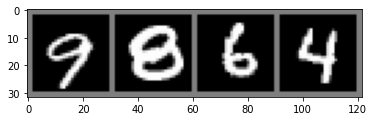

In [36]:
data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size = 4,
                                          shuffle = True)
X_test, y_test = next(iter(data_loader_test))
inputs = get_variable(X_test)
pred = cnn_model(inputs)
_,pred = torch.max(pred, 1)

print("Predict Label is:", [ i for i in pred.data])
print("Real Label is:",[i for i in y_test])

img = torchvision.utils.make_grid(X_test)
img = img.numpy().transpose(1,2,0)

std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
plt.imshow(img)
    